In [105]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [106]:
MOOD_MAPPING = {
    0: 'sadness',
    1: 'joy', 
    2: 'love', 
    3: 'anger', 
    4: 'fear', 
    5: 'surprise'
}

In [107]:
DATA_PATH = 'Mood-Data/'  
TRAIN_FILE = 'Mood_training.csv'
TEST_FILE = 'Mood_test.csv'
VAL_FILE = 'Mood_validation.csv'

In [108]:
# Parameter untuk Tokenizer
MAX_WORDS = 10000  # Jumlah kata maksimal dalam vocabulary
MAX_LEN = 150  # Panjang maksimal sequence
PADDING_TYPE = 'post'
TRUNCATING_TYPE = 'post'
OOV_TOKEN = '<OOV>'

In [109]:
def load_data(file_path):
    """Membaca data CSV dan mengembalikan teks dan labelnya."""
    data = pd.read_csv(file_path)
    texts = data['text'].values  # Asumsi kolom teks bernama 'text'
    moods = data['label'].values  # Asumsi kolom label bernama 'mood'
    return texts, moods

X_train, y_train = load_data(DATA_PATH + TRAIN_FILE)
X_test, y_test = load_data(DATA_PATH + TEST_FILE)
X_val, y_val = load_data(DATA_PATH + VAL_FILE)

In [110]:
print(X_train, y_train)
print(X_test, y_test)
print(X_val, y_val)


['i didnt feel humiliated'
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'
 'im grabbing a minute to post i feel greedy wrong' ...
 'i feel strong and good overall'
 'i feel like this was such a rude comment and im glad that t'
 'i know a lot but i feel so stupid because i can not portray it'] [0 0 3 ... 1 3 0]
['im feeling rather rotten so im not very ambitious right now'
 'im updating my blog because i feel shitty'
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her'
 ...
 'i feel that i am useful to my people and that gives me a great feeling of achievement'
 'im feeling more comfortable with derby i feel as though i can start to step out my shell'
 'i feel all weird when i have to meet w people i text but like dont talk face to face w'] [0 0 0 ... 1 1 4]
['im feeling quite sad and sorry for myself but ill snap out of it soon'
 'i feel like i am still looking at a blank ca

In [111]:
encoder = OneHotEncoder(sparse_output=False) # Changed 'sparse' to 'sparse_output' 
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

In [ ]:
# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)


In [ ]:
def create_mood_detection_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Instansiasi Model
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(MOOD_MAPPING)
model = create_mood_detection_model(vocab_size, MAX_LEN, num_classes)

c:\Users\M S I\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# **Step 4: Training**
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train_onehot,
    validation_data=(X_val_padded, y_val_onehot),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.2893 - loss: 2.3314 - val_accuracy: 0.3520 - val_loss: 1.6439
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.3384 - loss: 1.5752 - val_accuracy: 0.5515 - val_loss: 1.1249
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.5915 - loss: 1.0669 - val_accuracy: 0.7015 - val_loss: 0.8321
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.7169 - loss: 0.8125 - val_accuracy: 0.7405 - val_loss: 0.7193
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.7403 - loss: 0.7072 - val_accuracy: 0.7610 - val_loss: 0.6623
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.7679 - loss: 0.6361 - val_accuracy: 0.7945 - val_loss: 0.5667
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.8041 - loss: 0.5313 - val_accuracy: 0.8055 - val_loss: 0.5272
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.8098 - loss: 0

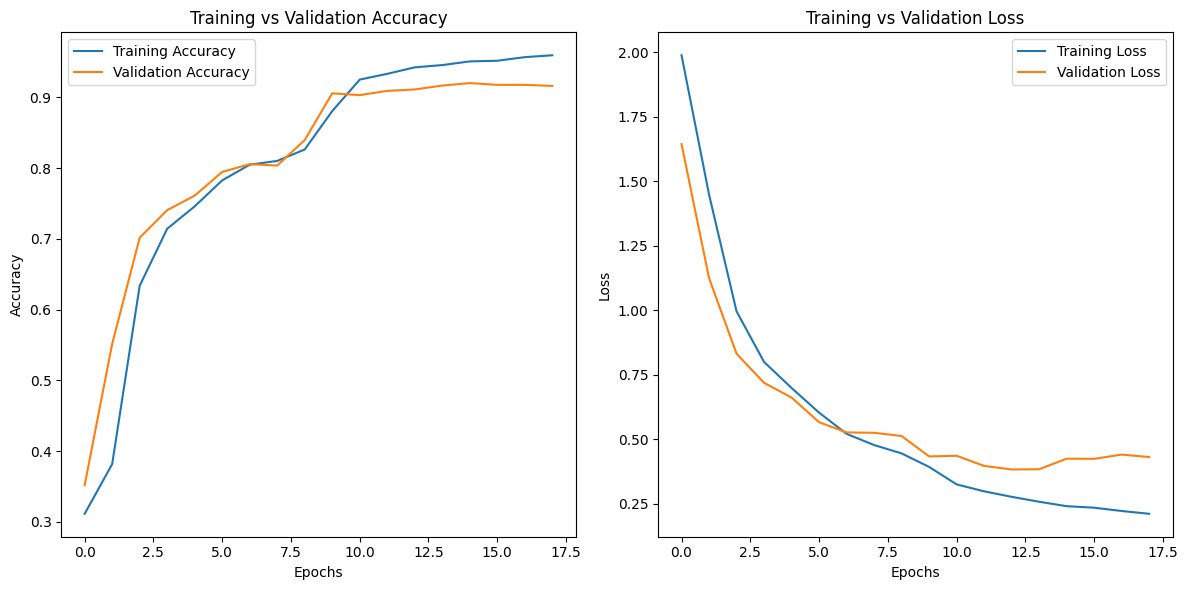

In [ ]:
# **Step 6: Plot Training History**
def plot_history(history):
    """Mem-plot grafik training dan validation loss/accuracy."""
    # Plotting Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk mem-plot hasil training
plot_history(history)


In [117]:
# Prediksi pada data uji
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [ ]:
# Laporan evaluasi
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=list(MOOD_MAPPING.values())))


Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.93      0.94       695
        love       0.75      0.87      0.80       159
       anger       0.92      0.90      0.91       275
        fear       0.87      0.88      0.88       224
    surprise       0.62      0.56      0.59        66

    accuracy                           0.91      2000
   macro avg       0.84      0.85      0.85      2000
weighted avg       0.91      0.91      0.91      2000



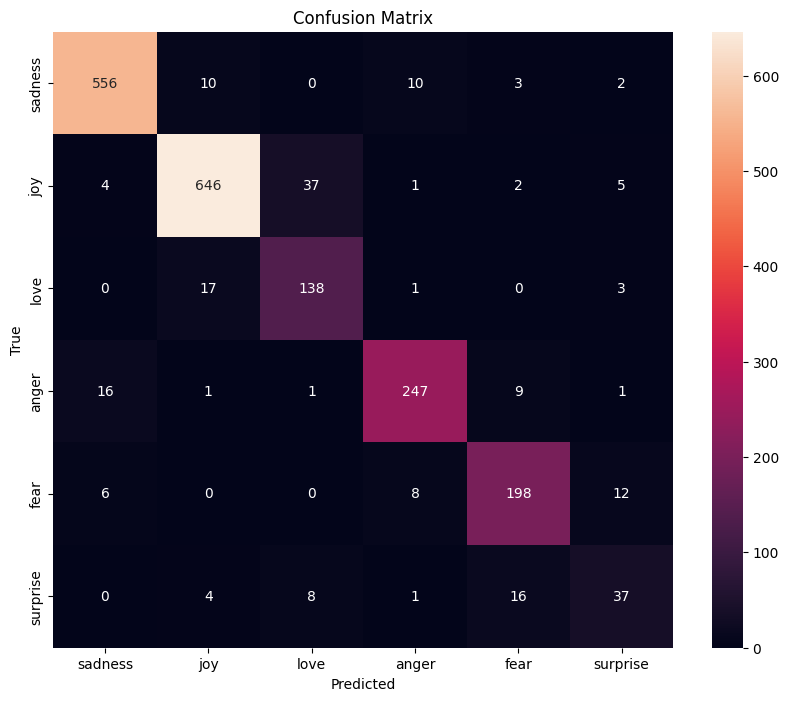

In [119]:
# Matriks kebingungan
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=list(MOOD_MAPPING.values()), yticklabels=list(MOOD_MAPPING.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [120]:
# **Step 5: Evaluation**
loss, accuracy = model.evaluate(X_test_padded, y_test_onehot)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9135 - loss: 0.4139
Test Loss: 0.38183286786079407, Test Accuracy: 0.9110000133514404


In [ ]:
def predict_mood(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
    prediction = model.predict(padded)[0]
    predicted_class = np.argmax(prediction)
    mood = MOOD_MAPPING[predicted_class]
    confidence_scores = {MOOD_MAPPING[i]: round(prediction[i] * 100, 2) for i in range(len(prediction))}
    return mood, confidence_scores

In [129]:
# Contoh Prediksi
sample_text = "i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight"
mood, scores = predict_mood(sample_text)
print(f"Predicted Mood: {mood}")
print("Confidence Scores:", scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Mood: anger
Confidence Scores: {'sadness': 1.07, 'joy': 0.0, 'love': 0.0, 'anger': 98.69, 'fear': 0.23, 'surprise': 0.01}
